# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [79]:
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

import pandas as pd
import nltk
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import seaborn as sns
import re

%matplotlib inline

In [80]:
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [81]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   article_id  45993 non-null  float64
 1   title       45993 non-null  object 
 2   email       45976 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [83]:
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   doc_body         1042 non-null   object
 1   doc_description  1053 non-null   object
 2   doc_full_name    1056 non-null   object
 3   doc_status       1056 non-null   object
 4   article_id       1056 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 41.4+ KB


In [84]:
df.describe(include = 'all')

,article_id,title,email
count,45993.000000,45993,45976
unique,NaN,714,5148
top,NaN,use deep learning for image classification,2b6c0f514c2f2b04ad3c4583407dccd0810469ee
freq,NaN,937,364
mean,908.846477,NaN,NaN
std,486.647866,NaN,NaN
min,0.000000,NaN,NaN
25%,460.000000,NaN,NaN
50%,1151.000000,NaN,NaN
75%,1336.000000,NaN,NaN


In [85]:
df_content.describe(include = 'all')

,doc_body,doc_description,doc_full_name,doc_status,article_id
count,1042,1053,1056,1056,1056.000000
unique,1036,1022,1051,1,NaN
top,Working Vis * \r\n * \r\n\r\n * Home\r\n * Abo...,Here’s this week’s news in Data Science and Bi...,How smart catalogs can turn the big data flood...,Live,NaN
freq,4,16,2,1056,NaN
mean,NaN,NaN,NaN,NaN,523.913826
std,NaN,NaN,NaN,NaN,303.480641
min,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,260.750000
50%,NaN,NaN,NaN,NaN,523.500000
75%,NaN,NaN,NaN,NaN,786.250000


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [86]:
# how many null values are in interactions
df.isnull().sum()

article_id     0
title          0
email         17
dtype: int64

In [87]:
# how many null values are in community
df_content.isnull().sum()

doc_body           14
doc_description     3
doc_full_name       0
doc_status          0
article_id          0
dtype: int64

In [88]:
# measure user interaction
user_interaction = df.email.value_counts()

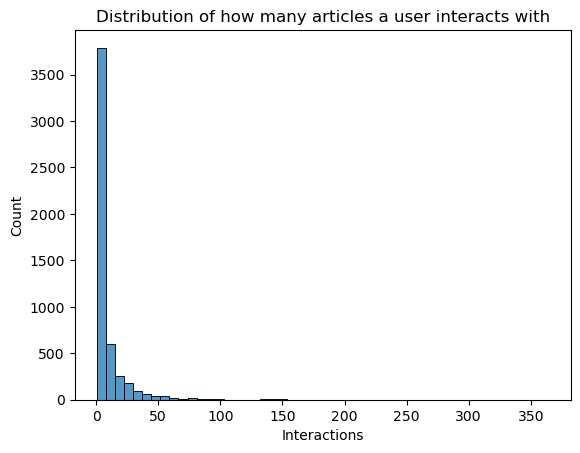

In [89]:
sns.histplot(user_interaction, bins = 50)
plt.title('Distribution of how many articles a user interacts with')
plt.xlabel('Interactions')
plt.ylabel('Count')
plt.show()

In [90]:
# Fill in the median and maximum number of user_article interactions below

median_val = np.median(user_interaction) # 50% of individuals interact with 3 number of articles or fewer.
max_views_by_user = np.max(user_interaction) # The maximum number of user-article interactions by any 1 user is 364.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [91]:
# Find and explore duplicate articles
articles_dup = df_content.article_id.duplicated().value_counts()[1]

In [92]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset = ['article_id'], inplace = True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [93]:
most_articles = df.article_id.value_counts(dropna = True)

In [94]:
# The number of unique articles that have at least one interaction
unique_articles = len(most_articles)

In [95]:
# The number of unique articles on the IBM platform
total_articles = len(df_content.article_id)

In [96]:
# The number of unique users
unique_users = len(user_interaction)

In [97]:
# The number of user-article interactions
user_article_interactions = df.shape[0]

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [98]:
# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = str(most_articles.index[0])

In [99]:
# The most viewed article in the dataset was viewed how many times?
max_views = most_articles.iloc[0]

In [100]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [101]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [102]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    
    # Get articles most interacted with
    article_ids = list(df['article_id'].value_counts().index[:n])
    
    top_articles = []

    # Get title of articles
    for i in article_ids:
        title = df[df['article_id'] == i]['title'].iloc[1]
        top_articles.append(title)
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Get articles most interacted with
    top_articles = list(df['article_id'].value_counts().index[:n])
    
    return top_articles # Return the top article ids

In [103]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [104]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [105]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_item = df.groupby(['user_id', 'article_id'])['title'].count().unstack()
    user_item = user_item.notnull().astype(int)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [106]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [107]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    user_vector = user_item.loc[user_id]
    dot_product = user_item.dot(user_vector)

    # sort by similarity
    dot_product = dot_product.sort_values(ascending = False)

    # create list of just the ids
    most_similar_users = list(dot_product.index)

    # remove the own user's id
    most_similar_users.remove(user_id)
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [108]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [109]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) interactions as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''

    # Initialize empty list to store article names
    article_names = []

    # Loop through the article ids
    for id in article_ids:
        # Filter the dataframe to get the row where article id matches with the current id in the loop
        name = df[df['article_id'] == float(id)]['title'].iloc[0]
        # Append the article name to the list
        article_names.append(name)
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Get the row corresponding to the user_id
    user_row = user_item.loc[user_id]

    # Get the article ids seen by the user
    article_ids = user_row[user_row == 1].index.astype(str).tolist()

    # Get the article names associated with the article ids
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Find the article the user has already seen
    seen_article_ids, _ = get_user_articles(user_id)

    # Find the closest users to the input user
    closest_users = find_similar_users(user_id)

    # Initialize a list to store recommended articles
    recs = []

    # Loop through closest users
    for user in closest_users:
        # Find the articles the closest user has seen
        user_seen_article_ids, _ = get_user_articles(user)

        # Find the articles the closest user has seen but the input user is yet to see
        new_article_ids = list(set(user_seen_article_ids) - set(seen_article_ids))


        # Append the new articles to the list of recommended articles
        recs.extend(new_article_ids)

        if len(recs) >= m:
            break
    
    return recs[:m] # return your recommendations for this user_id    

In [110]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['using github for project control in dsx',
 'spark 2.1 and job monitoring available in dsx',
 'modeling energy usage in new york city',
 'analyze accident reports on amazon emr spark',
 'a dynamic duo – inside machine learning – medium',
 'small steps to tensorflow',
 'recent trends in recommender systems',
 'experience iot with coursera',
 'optimizing a marketing campaign: moving from predictions to actions',
 'get social with your notebooks in dsx']

In [111]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [112]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int) the user id for which the recommendation will be generated
    df - (pandas dataframe) a dataframe that stores the interactions between users and articles
    user_item - (pandas dataframe) a matrix that represents the interactions between users and articles,
                with 1's representing the presence of an interaction and 0's representing the absence
                
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with columns:
                    neighbor_id - the id of a neighbor user
                    similarity - a measure of the similarity between the input user and each neighbor user
                    num_interactions - the number of articles viewed by the neighbor user
                    
    The dataframe is sorted in descending order first by similarity and then by num_interactions.
    '''
    
    # Calculate the number of interactions for each user
    user_interactions = df.groupby(['user_id'])['article_id'].count()
    
    # Obtain the list of neighbor user ids (excluding the input user)
    num_users = user_item.shape[0]
    neighbor_id = [id for id in range(1, num_users) if id != user_id]
    
    # Calculate the similarity score and number of interactions for each neighbor user
    similarity = []
    num_interactions = []
    for id in neighbor_id:
        similar = np.dot(user_item.loc[user_id], user_item.loc[id])
        similarity.append(similar)
        num_interactions.append(user_interactions.loc[id])
    
    # Create a dataframe from the similarity scores and number of interactions
    neighbors_df = pd.DataFrame({'neighbor_id': neighbor_id, 
                                'similarity': similarity, 
                                'num_interactions': num_interactions})
    
    # Sort the dataframe by similarity and number of interactions
    neighbors_df = neighbors_df.sort_values(by = ['similarity', 'num_interactions'], ascending = [False, False])
        
    return neighbors_df # Return the sorted dataframe

In [113]:
def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Get the articles the input user has already seen
    seen_article_ids, _ = get_user_articles(user_id)

    # Get the closest users
    closest_users = get_top_sorted_users(user_id)['neighbor_id'].tolist()
    
    # Initialize the list of recommended articles
    recs = []
    for user in closest_users:
        # Get the articles the closest user has seen
        user_seen_article_ids, _ = get_user_articles(user)
        # Find the articles the closest user has seen but the input user is yet to see
        new_article_ids = list(set(user_seen_article_ids) - set(seen_article_ids))
        # Append the new articles to the list of recommended articles
        recs.extend(new_article_ids)
        # If the number of recommended articles exceeds m, break
        if len(recs) >= m:
            break

    # If the number of recommended articles is less than m, choose the most popular articles
    if len(recs) < m:
        remaining = m - len(recs)
        most_popular = get_top_article_ids(df.shape[0])
        recs.extend(most_popular[:remaining])
    
    rec_names = get_article_names(recs)
   
    return recs, rec_names

In [114]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['205.0', '109.0', '1409.0', '555.0', '1304.0', '1160.0', '1386.0', '981.0', '1331.0', '1433.0', '1150.0', '1360.0', '939.0', '1411.0', '1151.0', '1278.0', '1335.0', '465.0', '164.0', '1336.0', '1351.0', '730.0', '1296.0', '1154.0', '1424.0', '1162.0', '793.0', '362.0', '1153.0', '1166.0', '1172.0', '1426.0', '302.0', '1276.0', '142.0', '761.0', '681.0', '1085.0', '1176.0', '1157.0', '1346.0', '1396.0', '1329.0', '1170.0', '1152.0', '1407.0', '1410.0', '1024.0', '1163.0', '651.0', '1427.0', '880.0', '911.0', '125.0', '1356.0', '1354.0', '1444.0', '1368.0', '1338.0', '1367.0', '12.0', '1330.0', '686.0', '1357.0', '1420.0', '336.0', '1391.0', '1324.0', '1364.0']

The top 10 recommendations for user 20 are the following article names:
["a beginner's guide to variational methods", 'tensorflow quick tips', 'uci: red wine quality', 'build a naive-bayes model with wml & dsx', 'gosales transactions for logistic regression mo

`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [115]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).iloc[0][0] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[9][0] # Find the 10th most similar user to user 131

In [116]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

For a new user, the **get_top_articles** function can be utilized to provide recommendations for the most popular articles. Additionally, incorporating a **knowledge-based** recommendation system that takes into account the user's preferences and matches them with relevant information in the database can further enhance the recommendations.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [117]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = [str(x) for x in get_top_article_ids(10)]

In [118]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

In [119]:
def tokenize(text):
    '''
    Tokenizes and performs pre-processing on text data.

    INPUT:
    text - the text data to be pre-processed

    OUTPUT:
    lemmas - the pre-processed text data in the form of a list of lemmas
    '''
    
    # Remove punctuation, special characters and spaces
    text = re.sub(r'[^a-zA-Z0-9]+', ' ', text)
    text = text.lower()
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words]
    
    # Perform lemmatization on the tokens
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
        
    return lemmas

First step is to find similarities between articles

In [120]:
def create_article_content(df= df, df_content=df_content):
    '''
    Description:
    Creates a combined dataframe containing all articles in the platform and their content.

    INPUT:
    df - pandas dataframe describing user interaction with the articles
    df_content - pandas dataframe describing articles on the platform

    OUTPUT:
    articles - pandas dataframe containing all articles in the platform, with their titles
    article_content - pandas dataframe describing the content of each article on the platform, 
                      based on the article title

    '''
    # Create a dataframe with the article_id and title columns from the interaction dataframe
    article_title_df = df[['article_id', 'title']]
    
    # Create a dataframe with the article_id and doc_full_name columns from the content dataframe
    article_title_df_content = pd.DataFrame({'article_id' : df_content.article_id, 'title' : df_content.doc_full_name})

    # Concatenate the two dataframes into a single dataframe, removing any duplicates
    articles = pd.concat([article_title_df, article_title_df_content])
    articles.drop_duplicates(subset = 'article_id', inplace = True)
    
    # Sort the dataframe by article_id
    articles.sort_values(by = 'article_id', inplace = True)
    
    # Reset the index of the dataframe
    articles.reset_index(drop = True, inplace = True)

    # Create a TfidfVectorizer object and fit it to the title values
    vectorizer = TfidfVectorizer(tokenizer=tokenize)
    vector = pd.DataFrame(vectorizer.fit_transform(articles['title'].values).toarray(), columns = [*vectorizer.vocabulary_])
    
    # Concatenate the article_title dataframe with the vectorized dataframe
    article_content = pd.concat([articles, vector], axis = 1)
  
    return articles, article_content

articles, article_content = create_article_content()

To establish similarity, I created both a cosine similarity function and dot similarity function. Both functions produce similar if not same output

In [121]:
from sklearn.metrics.pairwise import cosine_similarity

def cosine_article_similarity(df=article_content):
    '''
    INPUT:
    df - pandas dataframe describe articles content
    OUTPUT:
    article_content -  pandas dataframe describe articles similarities

    Description:
    Return a pandas dataframe that describe the articles similarities
    using the cosine similarity.
    '''

    content = np.array(article_content.iloc[:, 2:])
    
    # Calculate cosine similarity between articles
    cosine_sim = cosine_similarity(content)
    
    # Convert cosine similarity array to a dataframe
    article_similarity = pd.DataFrame(cosine_sim, columns=article_content.article_id, index=article_content.article_id)
    
    return article_similarity

cosine_article_similarity = cosine_article_similarity()
cosine_article_similarity.head()

article_id,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
article_id,,,,,,,,,,,,,,,,,,,,,
0.0,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
1.0,0.0,1.000000,0.101443,0.0,0.023767,0.033650,0.0,0.032382,0.125929,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.032878,0.015730,0.0,0.0,0.0
2.0,0.0,0.101443,1.000000,0.0,0.027647,0.039144,0.0,0.037669,0.347816,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.038246,0.018298,0.0,0.0,0.0
3.0,0.0,0.000000,0.000000,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4.0,0.0,0.023767,0.027647,0.0,1.000000,0.035248,0.0,0.033919,0.034321,0.111562,...,0.0,0.0,0.0,0.0,0.0,0.034440,0.016477,0.0,0.0,0.0


In [122]:
def dot_article_similarity(df=article_content):
    '''
    INPUT:
    df - pandas dataframe describing articles content
    OUTPUT:
    article_similarity -  pandas dataframe describing articles similarities

    Description:
    Return a pandas dataframe that describes the articles similarities
    using the dot product.
    '''
    content = np.array(article_content.iloc[:, 2:])

    # Calculate the dot product of the articles
    dot_product = content.dot(content.T)

    # Replace the diagonal values with 0 to remove self-similarity
    article_similarity = pd.DataFrame(dot_product,
                                      index=article_content.article_id,
                                      columns=article_content.article_id)

    return article_similarity

article_similarity = dot_article_similarity()
article_similarity.head()

article_id,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
article_id,,,,,,,,,,,,,,,,,,,,,
0.0,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
1.0,0.0,1.000000,0.101443,0.0,0.023767,0.033650,0.0,0.032382,0.125929,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.032878,0.015730,0.0,0.0,0.0
2.0,0.0,0.101443,1.000000,0.0,0.027647,0.039144,0.0,0.037669,0.347816,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.038246,0.018298,0.0,0.0,0.0
3.0,0.0,0.000000,0.000000,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4.0,0.0,0.023767,0.027647,0.0,1.000000,0.035248,0.0,0.033919,0.034321,0.111562,...,0.0,0.0,0.0,0.0,0.0,0.034440,0.016477,0.0,0.0,0.0


In [123]:
def make_content_recs(user_id, m=5, similar=article_similarity, threshold=0.5):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    similar - (pandas dataframe) pandas dataframe that describe the articles
    similarities using the dot product

    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    '''
    # Find the article id of the articles the user has interacted with
    article_ids, _ = get_user_articles(user_id)
    
    # Filter out the articles the user has already seen
    rec_ids = similar[similar.index.isin(article_ids)==False]


    
    # Select the articles with similarity scores higher than the threshold
    rec_ids = rec_ids[rec_ids.sum(axis=1) >= threshold]
    
    # Sort the recommendations by the sum of their similarity scores
    rec_ids = rec_ids.sum(axis=1).sort_values(ascending=False)
    
    # Get the article ids and names of the top m recommendations
    recs = rec_ids.index[:m].tolist()
    rec_names = get_article_names(recs, df = articles)
    
    return recs, rec_names

Using NLP and similarity concepts, I created a content based recommender for users of the IBM platform

In [124]:
# Get user id who only has interacted with article id '1427.0'
df_1427 = df[df['article_id'] == 1427.0].groupby('user_id').count()
user_1427 = df_1427.sort_values('article_id').index[0]

# Make recomendation
make_content_recs(user_1427)

([168.0, 241.0, 272.0, 934.0, 893.0],
 ['Node.js data science notebooks – IBM Watson Data Lab – Medium',
  'i am not a data scientist – ibm watson data lab',
  'Simple data visualization in Apache CouchDB™ – IBM Watson Data Lab – Medium',
  'Load Cloudant Data in Apache Spark Using a Python Notebook',
  'Use the Machine Learning Library in IBM Analytics for Apache Spark'])

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [125]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [126]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [127]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

In the lesson, we applied SVD to a matrix with non-zero values, and Funk SVD to a matrix with missing values. This matrix contains binary values (0 or 1) and has no missing values, making SVD suitable for the matrix.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

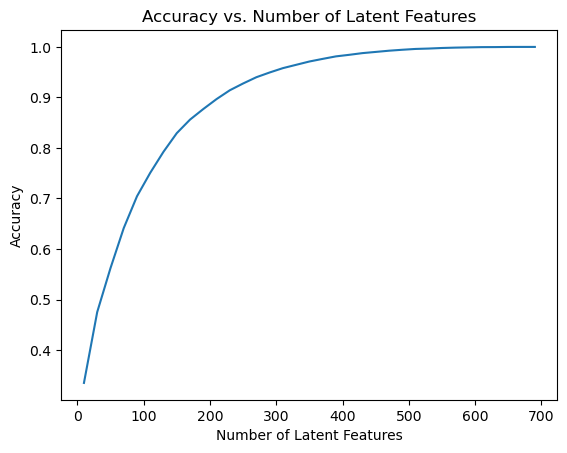

In [128]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [129]:
df_train = df.head(40000)
df_test = df.tail(5993)

In [130]:
def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Create the user-item matrix for the training dataframe using the create_user_item_matrix function
    user_item_train = create_user_item_matrix(df_train)

    # Create the user-item matrix for the testing dataframe using the create_user_item_matrix function
    user_item_test = create_user_item_matrix(df_test)

    # Get the list of test user ids
    # test_idx = user_item_test.index.tolist()
    test_idx = user_item_test.index

    # Get the list of test article ids
    # test_arts = user_item_test.columns.tolist()
    test_arts = user_item_test.columns
    
    # Return the user-item matrices for both the training and testing dataframes, and the test user ids and test article ids
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [131]:
user_item_train.shape, user_item_test.shape

((4487, 714), (682, 574))

In [132]:
'How many users can we make predictions for in the test set?'
len(np.intersect1d(df_train['user_id'], df_test['user_id']))

'How many users in the test set are we not able to make predictions for because of the cold start problem?'
len(df_test['user_id'].unique()) - len(np.intersect1d(df_train['user_id'].unique(),df_test['user_id'].unique()))

'How many articles can we make predictions for in the test set?'
len(np.intersect1d(df_train['article_id'],df_test['article_id']))

'How many articles in the test set are we not able to make predictions for because of the cold start problem?'
len(df_test['article_id'].unique()) - len(np.intersect1d(df_train['article_id'].unique(),df_test['article_id'].unique()))


0

In [133]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [134]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [135]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

# Intersecting rows in train and test set
row_idx = user_item_train.index.isin(test_idx)
u_test = u_train[row_idx, :]

#  Intersecting columns in train and test set
col_idxs = user_item_train.columns.isin(test_arts)
vt_test = vt_train[:, col_idxs]

train_idx = user_item_train.index
row_idx_2 = user_item_test.index.isin(train_idx)
sub_user_item_test = user_item_test.loc[row_idx_2]

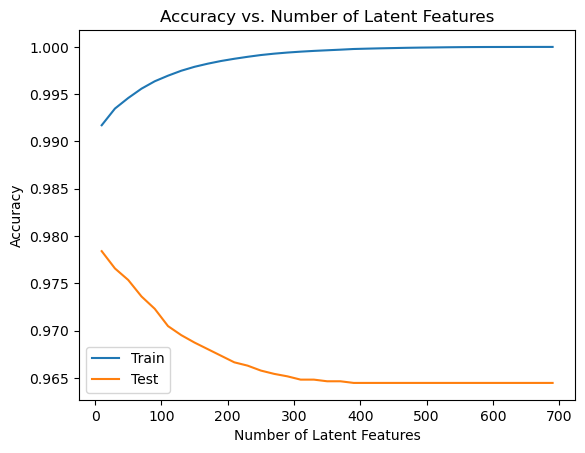

In [136]:
latent_feats = np.arange(10, 710, 20)

train_errs, test_errs = [], []


for k in latent_feats:
    # restructure with k latent features
    s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_train_preds = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))
    
    # compute prediction accuracy
    train_errs.append(accuracy_score(user_item_train.values.flatten(), user_item_train_preds.flatten()))
    test_errs.append(accuracy_score(sub_user_item_test.values.flatten(), user_item_test_preds.flatten()))


plt.figure()
plt.plot(latent_feats, train_errs, label='Train')
plt.plot(latent_feats, test_errs, label='Test')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.legend()
plt.show()

The accuracy of the model appears to be overly high in both training and testing, possibly due to the imbalanced nature of the dataset with a greater proportion of zeros. This could indicate overfitting of the model to the data. To improve the results and ensure the model generalizes well, it would be beneficial to use cross-validation techniques.

In [137]:
from subprocess import call
try:
    call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])
except Exception as e:
    print('An error occurred: ', str(e))

In [138]:
!jupyter nbconvert --to html Recommendations_with_IBM.ipynb

[NbConvertApp] Converting notebook Recommendations_with_IBM.ipynb to html
[NbConvertApp] Writing 843354 bytes to Recommendations_with_IBM.html
